In [ ]:
!pip install kaggle kagglehub numpy pandas scikit-learn seaborn tensorflow matplotlib scipy


In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hema33","key":"1284f9fe8ead75ebcd895061b2e664ef"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download latest version
import kagglehub
path = kagglehub.dataset_download("allandclive/chicken-disease-1")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chicken-disease-1


In [ ]:
import os

path ="/kaggle/input/chicken-disease-1"
for root, dirs, files in os.walk(path):
    print(f"📁 Folder: {root}")
    for file in files[:5]:  # Show only first 5 files per folder
        print(f"   - {file}")
    print()

📁 Folder: /kaggle/input/chicken-disease-1
   - train_data.csv

📁 Folder: /kaggle/input/chicken-disease-1/Train
   - cocci.104.jpg
   - ncd.339.jpg
   - salmo.1536.jpg
   - healthy.1034.jpg
   - salmo.1057.jpg



In [ ]:
import os
import shutil
src_dir = "/kaggle/input/chicken-disease-1/Train"

dst_dir = "/content/chicken_disease/Structured"
os.makedirs(dst_dir, exist_ok=True)

# Fix: updated prefix for New Castle Disease
class_map = {
    "cocci": "Coccidiosis",
    "healthy": "Healthy",
    "salmo": "Salmonella",
    "ncd": "New Castle Disease"
}

# Move images to class-specific folders
for img in os.listdir(src_dir):
    if not img.endswith(".jpg"):
        continue
    prefix = img.split(".")[0]
    for key in class_map:
        if prefix.startswith(key):
            class_name = class_map[key]
            class_dir = os.path.join(dst_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            shutil.copy(os.path.join(src_dir, img), os.path.join(class_dir, img))


In [ ]:
from sklearn.model_selection import train_test_split

src_root = "/content/chicken_disease/Structured"
dest_root = "/content/data/data"

# Create folders
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(src_root):
        os.makedirs(os.path.join(dest_root, split, class_name), exist_ok=True)

# Split data
for class_name in os.listdir(src_root):
    class_dir = os.path.join(src_root, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.jpg')]
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.1, random_state=42)

    for split_name, file_list in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        for f in file_list:
            dest_path = os.path.join(dest_root, split_name, class_name, os.path.basename(f))
            shutil.copy(f, dest_path)


In [ ]:
from keras.layers import Input,Lambda,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import pandas as pd

In [ ]:
IMAGE_SIZE=(224,224,3)

In [ ]:
train_data = "/content/data/data/train"
val_data   = "/content/data/data/val"
test_data  = "/content/data/data/test"


In [ ]:
import os
import cv2

labels = ['Coccidiosis', 'Salmonella', 'New Castle Disease', 'Healthy']
train_data = r"/content/data/data/train"

for cls in labels:
    folder_path = os.path.join(train_data, cls)
    if os.path.exists(folder_path):
        print(f"✅ {cls}: {len(os.listdir(folder_path))} files")
    else:
        print(f"⚠️ Missing folder: {folder_path}")


✅ Coccidiosis: 1513 files
✅ Salmonella: 1638 files
✅ New Castle Disease: 270 files
✅ Healthy: 1480 files


In [ ]:
import os
import cv2

labels = ['Coccidiosis', 'Salmonella', 'New Castle Disease', 'Healthy']
train_data = r"/content/data/data/train"

def read_data(folder):
    data, label, paths = [], [], []
    for l in labels:
        path = os.path.join(folder, l)
        if not os.path.exists(path):
            print(f"⚠️ Skipping missing folder: {path}")
            continue
        image_files = os.listdir(path)[:500]
        for image_file in image_files:
            img_path = os.path.join(path, image_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                data.append(img)
                label.append(l)
                paths.append(img_path)
            else:
                print(f"❌ Cannot read: {img_path}")
    return data, label, paths
all_data, all_labels, all_paths = read_data(train_data)

In [ ]:
train_df=pd.DataFrame({
    'image':all_data,
    'path':all_paths,
    'label':all_labels
})

In [ ]:
train_df

,image,path,label
0,"[[[66, 120, 153], [69, 123, 156], [77, 131, 16...",/content/data/data/train/Coccidiosis/cocci.178...,Coccidiosis
1,"[[[170, 184, 190], [172, 186, 192], [171, 185,...",/content/data/data/train/Coccidiosis/cocci.953...,Coccidiosis
2,"[[[99, 133, 162], [99, 136, 164], [99, 135, 16...",/content/data/data/train/Coccidiosis/cocci.169...,Coccidiosis
3,"[[[56, 106, 136], [66, 116, 146], [77, 127, 15...",/content/data/data/train/Coccidiosis/cocci.934...,Coccidiosis
4,"[[[13, 60, 92], [15, 62, 94], [24, 69, 102], [...",/content/data/data/train/Coccidiosis/cocci.342...,Coccidiosis
...,...,...,...
1765,"[[[103, 107, 112], [101, 105, 110], [105, 106,...",/content/data/data/train/Healthy/healthy.1048.jpg,Healthy
1766,"[[[89, 98, 95], [76, 85, 82], [115, 124, 121],...",/content/data/data/train/Healthy/healthy.642.jpg,Healthy
1767,"[[[175, 165, 158], [181, 171, 164], [189, 178,...",/content/data/data/train/Healthy/healthy.2029.jpg,Healthy
1768,"[[[102, 101, 103], [103, 102, 104], [107, 106,...",/content/data/data/train/Healthy/healthy.1644.jpg,Healthy


In [ ]:
import os
import cv2

labels = ['Coccidiosis', 'Salmonella', 'New Castle Disease', 'Healthy']
test_data = r"/content/data/data/test"

def read_data(folder):
    data, label, paths = [], [], []
    for l in labels:
        path = os.path.join(folder, l)
        if not os.path.exists(path):
            print(f"⚠️ Skipping missing folder: {path}")
            continue
        image_files = os.listdir(path)[:500]
        for image_file in image_files:
            img_path = os.path.join(path, image_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                data.append(img)
                label.append(l)
                paths.append(img_path)
            else:
                print(f"❌ Cannot read: {img_path}")
    return data, label, paths
all_data, all_labels, all_paths = read_data(test_data)

In [ ]:
test_df=pd.DataFrame({
    'image':all_data,
    'path':all_paths,
    'label':all_labels
})

In [ ]:
test_df

,image,path,label
0,"[[[112, 153, 186], [104, 147, 180], [105, 150,...",/content/data/data/test/Coccidiosis/cocci.1174...,Coccidiosis
1,"[[[148, 173, 193], [149, 174, 194], [154, 179,...",/content/data/data/test/Coccidiosis/cocci.1409...,Coccidiosis
2,"[[[60, 127, 176], [67, 135, 182], [72, 139, 18...",/content/data/data/test/Coccidiosis/cocci.1905...,Coccidiosis
3,"[[[6, 2, 7], [6, 2, 7], [6, 2, 7], [6, 2, 7], ...",/content/data/data/test/Coccidiosis/cocci.293.jpg,Coccidiosis
4,"[[[41, 66, 98], [2, 30, 64], [0, 31, 65], [21,...",/content/data/data/test/Coccidiosis/cocci.1257...,Coccidiosis
...,...,...,...
1360,"[[[115, 119, 124], [106, 110, 115], [102, 105,...",/content/data/data/test/Healthy/healthy.655.jpg,Healthy
1361,"[[[134, 138, 156], [133, 137, 156], [131, 136,...",/content/data/data/test/Healthy/healthy.1012.jpg,Healthy
1362,"[[[165, 162, 177], [173, 169, 180], [183, 176,...",/content/data/data/test/Healthy/healthy.102.jpg,Healthy
1363,"[[[196, 208, 210], [198, 210, 212], [195, 207,...",/content/data/data/test/Healthy/healthy.719.jpg,Healthy


In [ ]:
import os
import cv2

labels = ['Coccidiosis', 'Salmonella', 'New Castle Disease', 'Healthy']
val_data = r"/content/data/data/val"

def read_data(folder):
    data, label, paths = [], [], []
    for l in labels:
        path = os.path.join(folder, l)
        if not os.path.exists(path):
            print(f"⚠️ Skipping missing folder: {path}")
            continue
        image_files = os.listdir(path)[:500]
        for image_file in image_files:
            img_path = os.path.join(path, image_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                data.append(img)
                label.append(l)
                paths.append(img_path)
            else:
                print(f"❌ Cannot read: {img_path}")
    return data, label, paths
all_data, all_labels, all_paths = read_data(val_data)

In [ ]:
val_df=pd.DataFrame({
    'image':all_data,
    'path':all_paths,
    'label':all_labels
})

In [ ]:
val_df

,image,path,label
0,"[[[74, 110, 148], [85, 121, 159], [96, 130, 16...",/content/data/data/val/Coccidiosis/cocci.2058.jpg,Coccidiosis
1,"[[[58, 72, 84], [66, 80, 92], [63, 75, 87], [6...",/content/data/data/val/Coccidiosis/cocci.1129.jpg,Coccidiosis
2,"[[[18, 29, 37], [18, 29, 37], [15, 27, 37], [1...",/content/data/data/val/Coccidiosis/cocci.761.jpg,Coccidiosis
3,"[[[91, 138, 170], [37, 78, 110], [0, 28, 61], ...",/content/data/data/val/Coccidiosis/cocci.1986.jpg,Coccidiosis
4,"[[[90, 151, 185], [60, 123, 157], [57, 120, 15...",/content/data/data/val/Coccidiosis/cocci.523.jpg,Coccidiosis
...,...,...,...
541,"[[[179, 175, 174], [183, 179, 178], [172, 168,...",/content/data/data/val/Healthy/healthy.122.jpg,Healthy
542,"[[[204, 201, 197], [187, 186, 182], [166, 170,...",/content/data/data/val/Healthy/healthy.1925.jpg,Healthy
543,"[[[85, 84, 93], [86, 86, 92], [92, 90, 96], [1...",/content/data/data/val/Healthy/healthy.1776.jpg,Healthy
544,"[[[46, 57, 71], [43, 54, 68], [47, 59, 71], [5...",/content/data/data/val/Healthy/healthy.949.jpg,Healthy


In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [57]:

train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32
)

Found 1770 validated image filenames belonging to 4 classes.


In [58]:

test_gen = gen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32
)

Found 1365 validated image filenames belonging to 4 classes.


In [ ]:

val_gen = gen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32
)

Found 546 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [59]:
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=vgg.input, outputs=predictions)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,80

 Total params: 15,772,996 (60.17 MB)

 Trainable params: 1,055,236 (4.03 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
r = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 382ms/step - accuracy: 0.6432 - loss: 1.2059 - val_accuracy: 0.7656 - val_loss: 1.0777 - learning_rate: 0.0010
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.8552 - loss: 0.4278 - val_accuracy: 0.8315 - val_loss: 0.5536 - learning_rate: 0.0010
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.8841 - loss: 0.3406 - val_accuracy: 0.8516 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - accuracy: 0.8989 - loss: 0.2705 - val_accuracy: 0.8938 - val_loss: 0.3700 - learning_rate: 0.0010
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.9028 - loss: 0.2606 - val_accuracy: 0.8736 - val_loss: 0.3793 - learning_rate: 0.0010


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
vgg1 = VGG19(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in vgg1.layers:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = Flatten()(vgg1.output)
prediction = Dense(4, activation='softmax')(x)

In [ ]:
model1 = Model(inputs=vgg1.input, outputs=prediction)

In [ ]:
model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

In [ ]:
res = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in res.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(res.output)
prediction = Dense(4, activation='softmax')(x)

In [ ]:
model2 = Model(inputs=res.input, outputs=prediction)
model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
r = model1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 376ms/step - accuracy: 0.6783 - loss: 3.5669 - val_accuracy: 0.9011 - val_loss: 1.3981
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9564 - loss: 0.3430 - val_accuracy: 0.8828 - val_loss: 1.5291
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9893 - loss: 0.0771 - val_accuracy: 0.8993 - val_loss: 1.3629
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.8938 - val_loss: 1.3624
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9977 - loss: 0.0074 - val_accuracy: 0.9011 - val_loss: 1.4231


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def predictor(model, test_gen):
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)

    preds = model.predict(test_gen, verbose=1)
    errors = 0
    pred_indices = []
    test_count = len(preds)

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        pred_indices.append(pred_index)
        true_index = test_gen.labels[i]
        if pred_index != true_index:
            errors += 1

    accuracy = (test_count - errors) * 100 / test_count
    ytrue = np.array(test_gen.labels, dtype='int')
    ypred = np.array(pred_indices, dtype='int')

    msg = f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f}'
    print(msg)


    cm = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='d', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count)+0.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+0.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    clr = classification_report(ytrue, ypred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 462ms/step
There were 953 errors in 1365 tests for an accuracy of  30.18


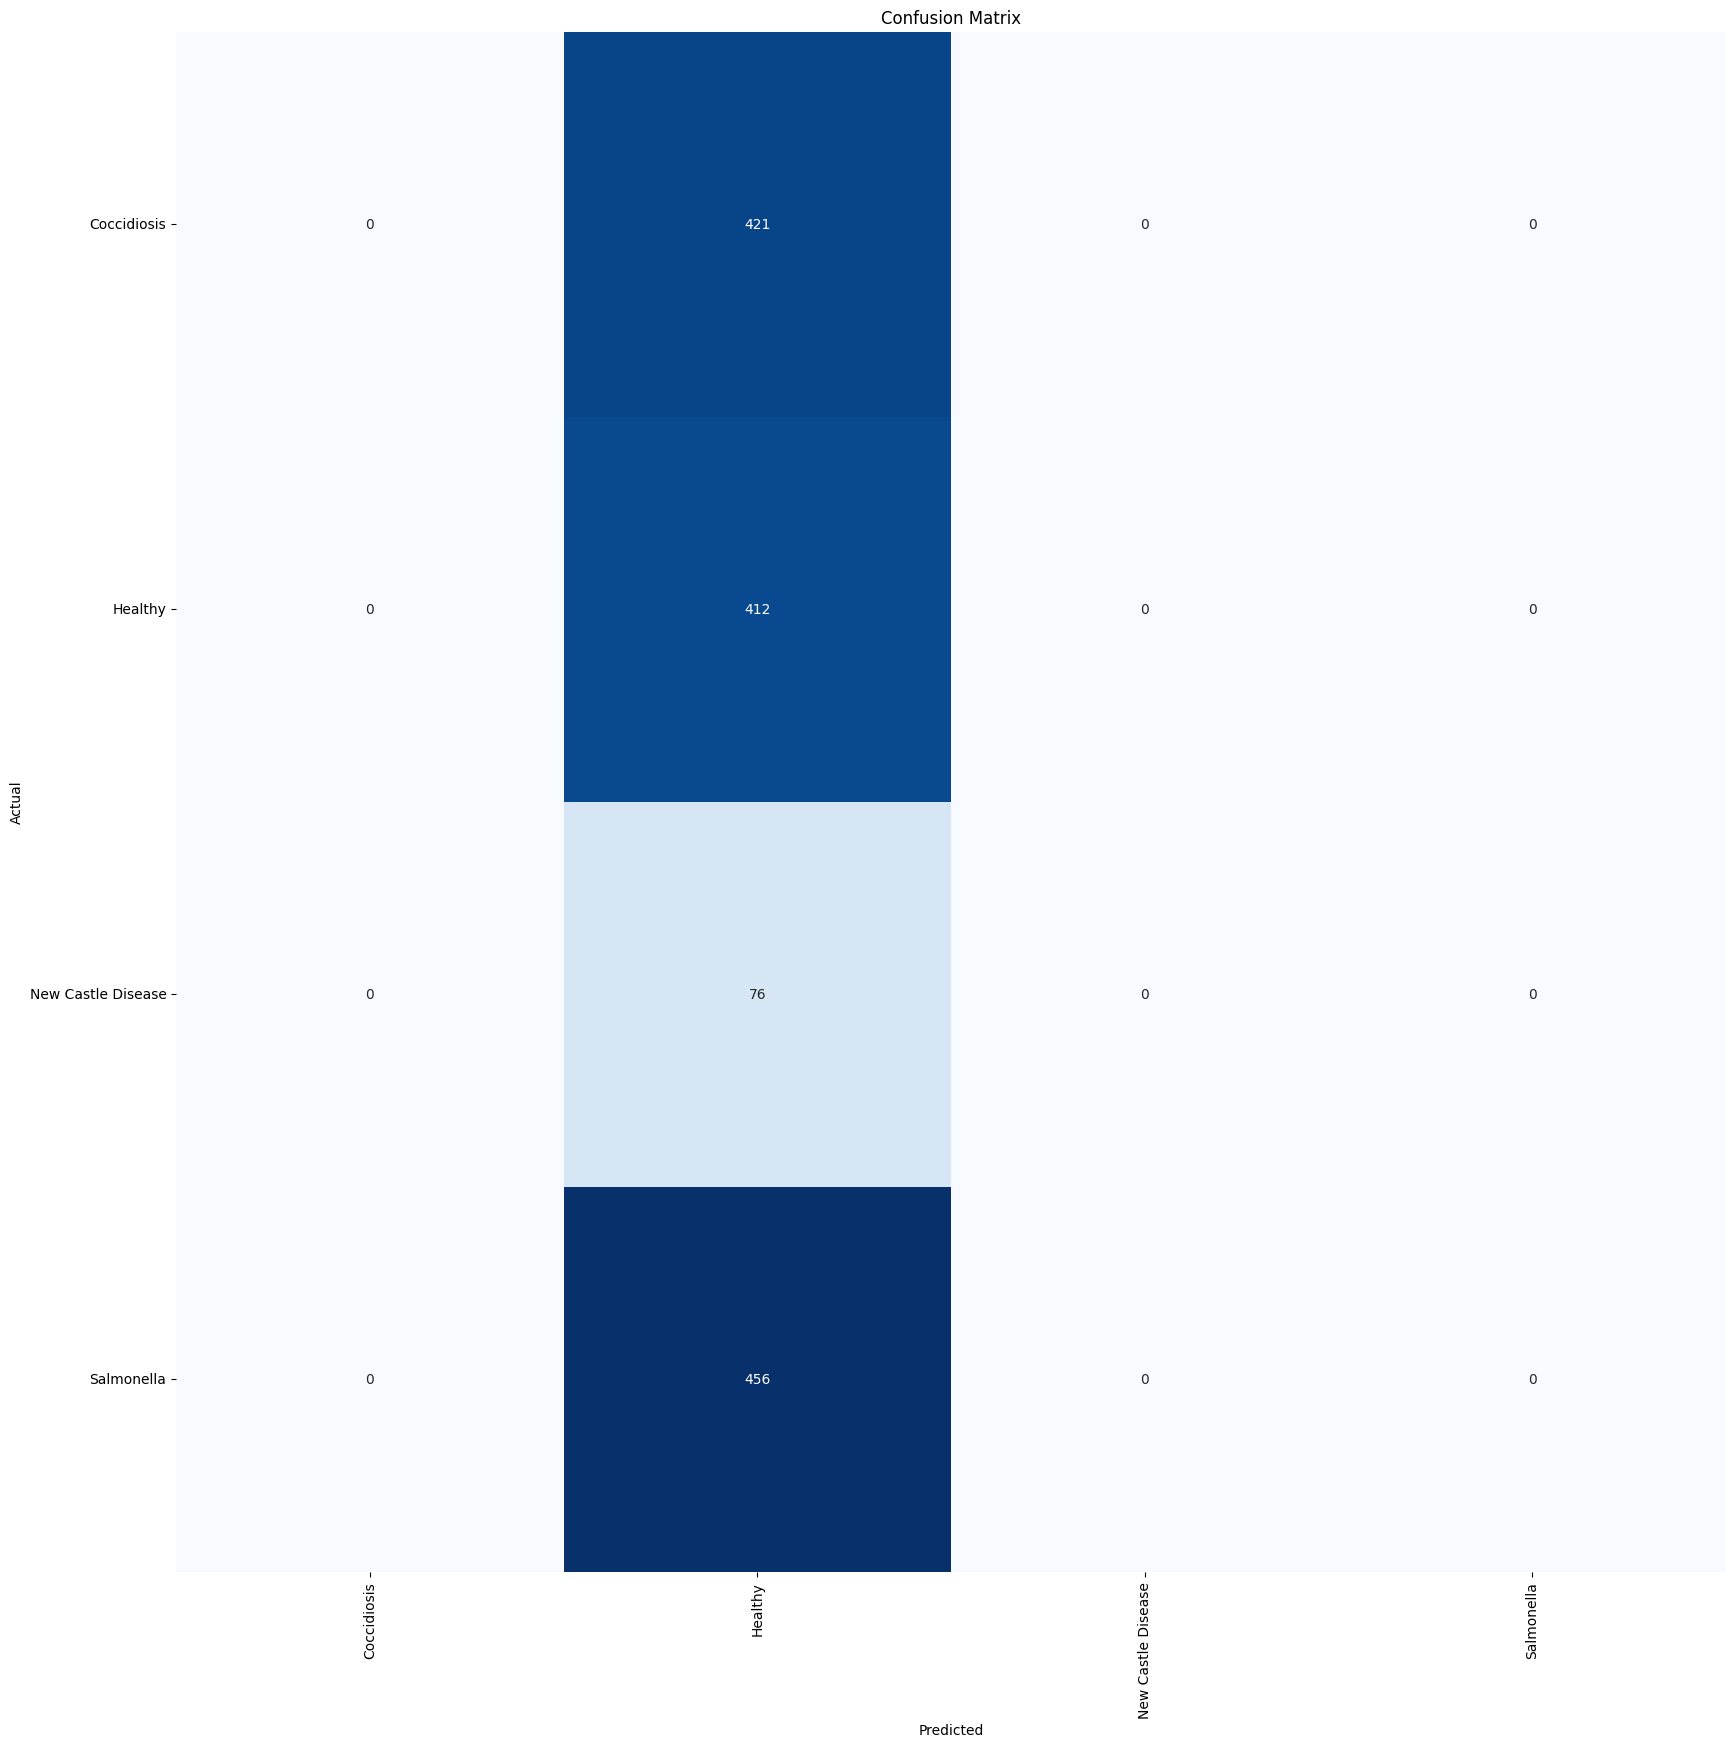

Classification Report:
----------------------



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
predictor(model,test_gen)

In [61]:
from keras.layers import GlobalAveragePooling2D

In [63]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [64]:
import keras_tuner as kt

In [69]:
def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Correct: learning_rate is used in optimizer, NOT in Dense()
    x = Dense(
        hp.Int('units', min_value=512, max_value=1024, step=512),
        activation='relu'
    )(x)

    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=3,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

#tuner.search(train_gen, steps_per_epoch=10, epochs=2, validation_data=val_gen, callbacks=[stop_early])


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal units: {best_hps.get('units')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


Reloading Tuner from my_dir/intro_to_kt/tuner0.json

Optimal units: 512
Optimal learning rate: 0.0003469331591486965

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 542ms/step - accuracy: 0.3340 - loss: 1.3593 - val_accuracy: 0.2601 - val_loss: 3.1032
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 417ms/step - accuracy: 0.4758 - loss: 1.2236 - val_accuracy: 0.2692 - val_loss: 4.5592
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 418ms/step - accuracy: 0.4935 - loss: 1.2034 - val_accuracy: 0.3022 - val_loss: 6.0436
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 420ms/step - accuracy: 0.4891 - loss: 1.1737 - val_accuracy: 0.3095 - val_loss: 7.6143
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 433ms/step - accuracy: 0.5151 - loss: 1.1199 - val_accuracy: 0.3095 - val_loss: 9.0745
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.4837 - loss: 1.1675 - val_accuracy: 0.3095 - val_loss: 9.9912
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 414ms/step - accuracy: 0.4854 - loss: 1.1469 - val_accuracy: 0.309

In [70]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [ ]:
train_gen.class_indices.keys()
labels = ['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella']
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
def get_model_prediction(image_path):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x, verbose=0)
    return labels[predictions.argmax()]

In [71]:
get_model_prediction('/content/data/data/test/Coccidiosis/cocci.1034.jpg')

'Coccidiosis'

In [72]:
get_model_prediction('/content/data/data/test/Healthy/healthy.1068.jpg')

'Coccidiosis'

In [73]:
get_model_prediction('/content/data/data/test/New Castle Disease/ncd.126.jpg')

'Coccidiosis'

In [74]:
get_model_prediction('/content/data/data/test/Salmonella/salmo.1024.jpg')

'Coccidiosis'

In [ ]:
model.save("model.h5")